# Codecademy portfolio project - Forest Cover Classification

In this notebook I present my solution to the final portfolio project of Codecademy's intro-level course to deep learning and tensorflow. Data was provided from codecademy on study geological aspects of the areas studied (obtained from the US Geological Survey and US Forest Service (USFS)), one observation being a 30x30 meter cell of forest. Labelling was determined from the USFS Region 2 Resource Information System data. 

Covertypes: 
- Spruce/Fir
- Lodgepole Pine
- Ponderosa Pine
- Cottonwood/Willow
- Aspen
- Douglas-fir
- Krummholz

581012 observations were provided with 54 features. 

### Import Packages

In [181]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical

### Import Data

In [5]:
data = pd.read_csv('cover_data.csv')

### EDA

In [8]:
data.shape

(581012, 55)

In [6]:
data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,class
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype
---  ------                              --------------   -----
 0   Elevation                           581012 non-null  int64
 1   Aspect                              581012 non-null  int64
 2   Slope                               581012 non-null  int64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  int64
 4   Vertical_Distance_To_Hydrology      581012 non-null  int64
 5   Horizontal_Distance_To_Roadways     581012 non-null  int64
 6   Hillshade_9am                       581012 non-null  int64
 7   Hillshade_Noon                      581012 non-null  int64
 8   Hillshade_3pm                       581012 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  int64
 10  Wilderness_Area1                    581012 non-null  int64
 11  Wilderness_Area2                    581012 non-null 

In [33]:
data['class'].value_counts(normalize=True)

2    0.487599
1    0.364605
3    0.061537
7    0.035300
6    0.029891
5    0.016339
4    0.004728
Name: class, dtype: float64

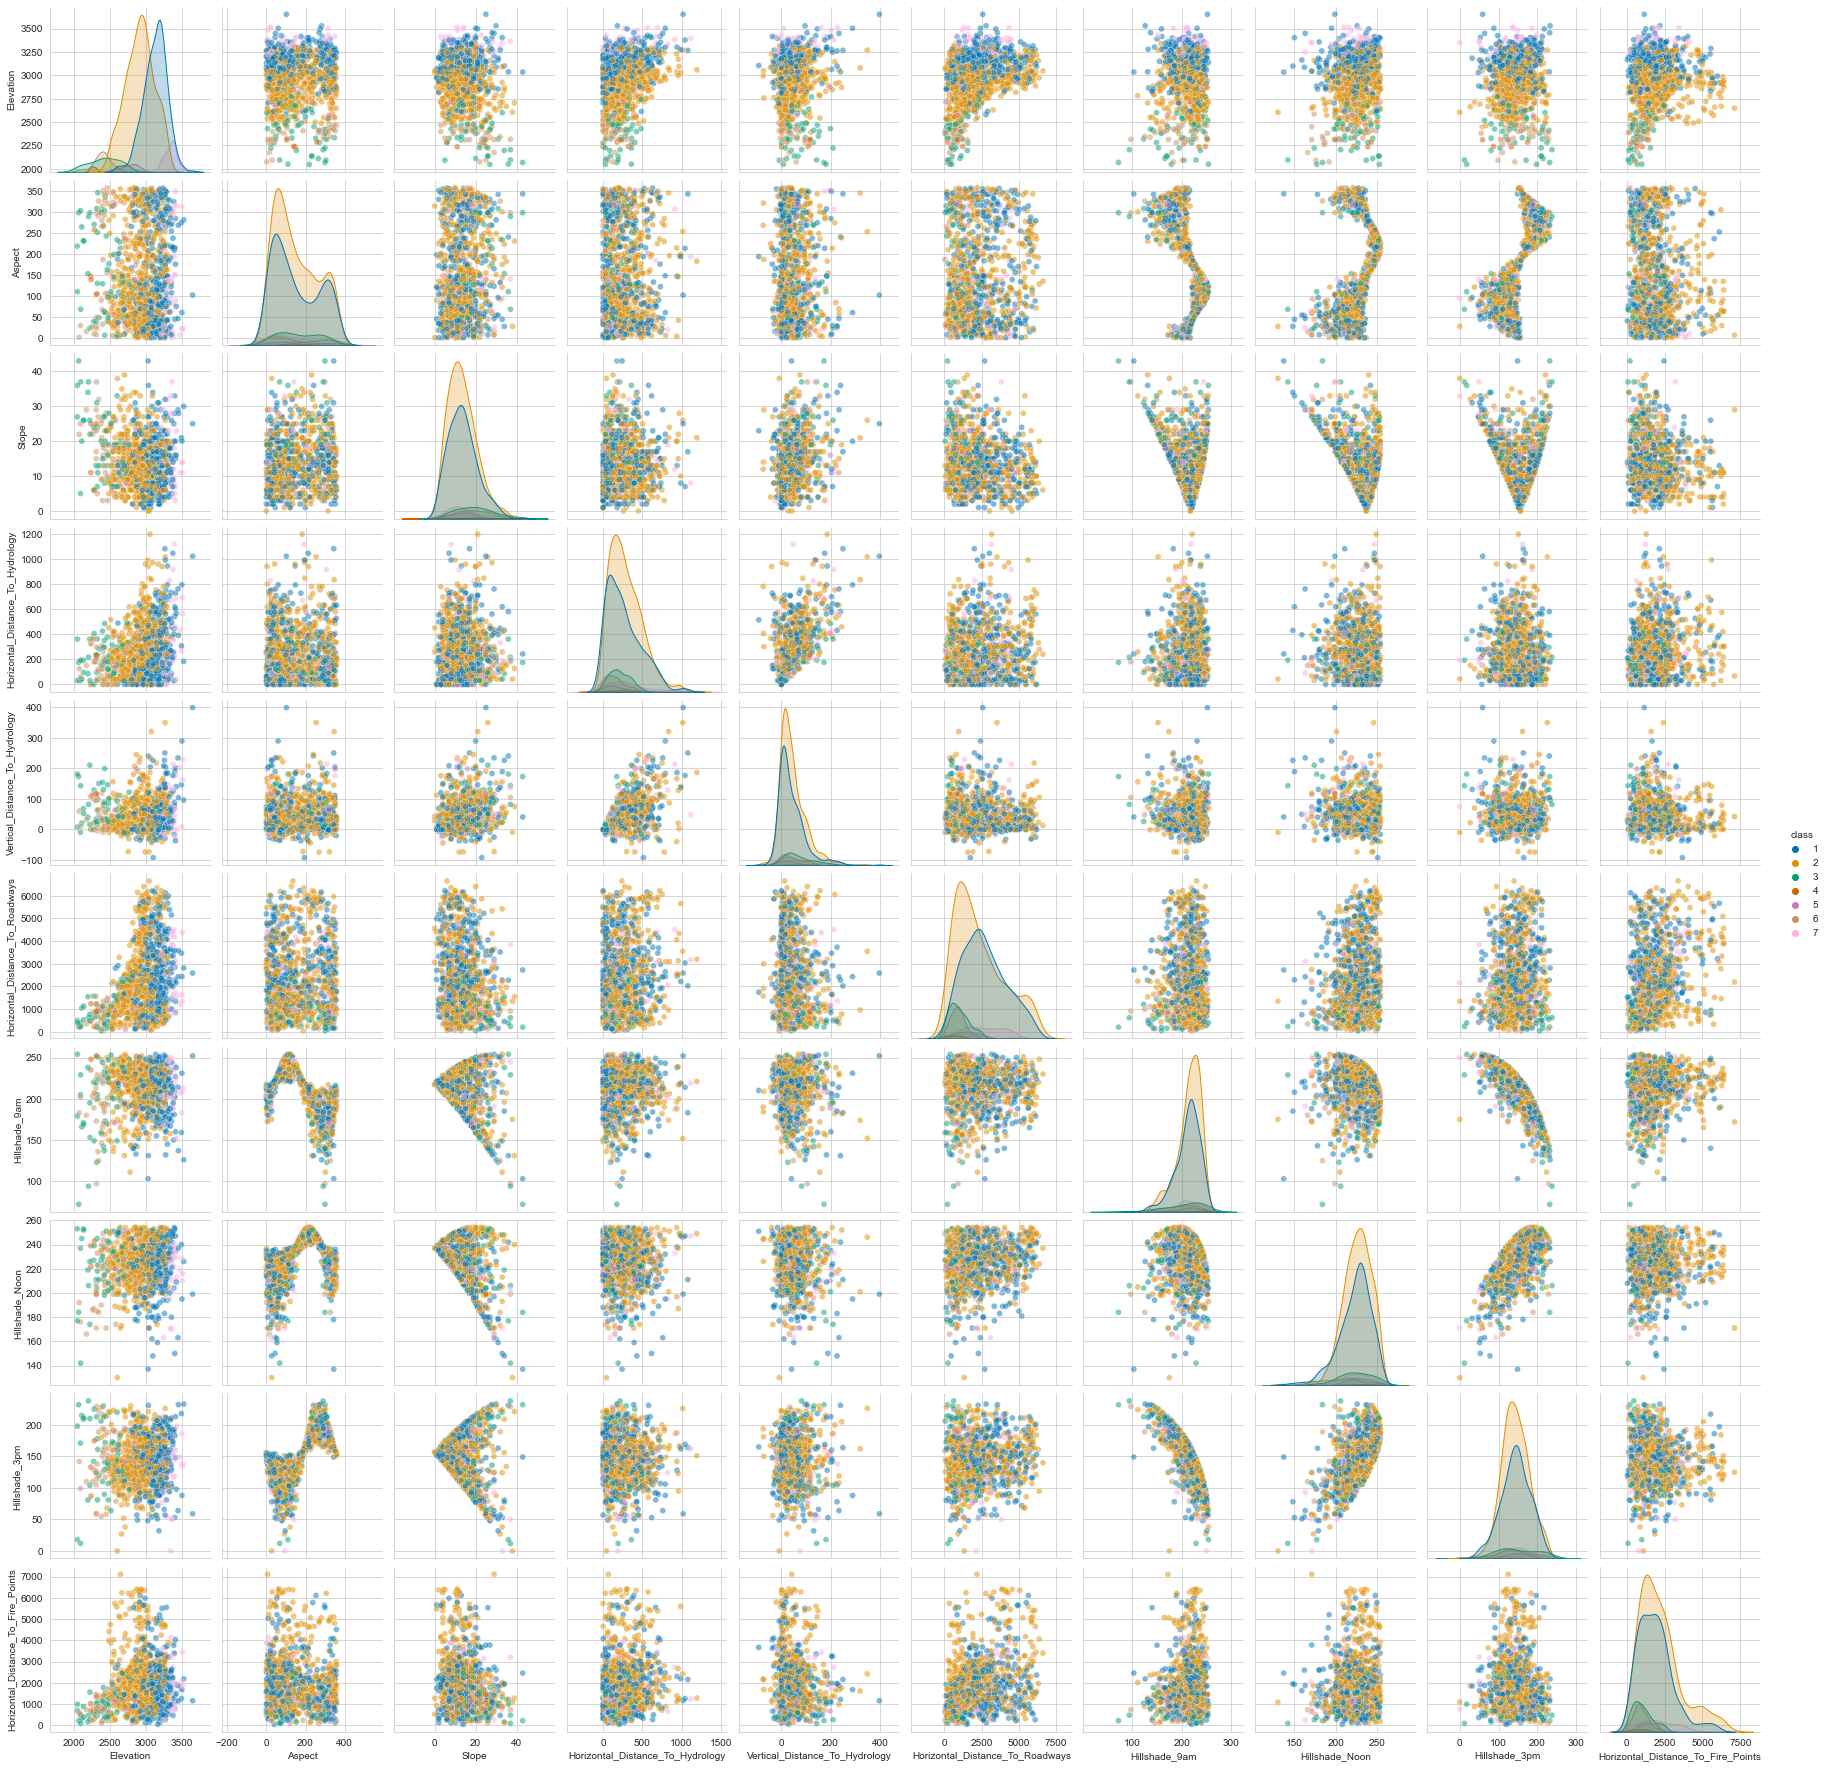

In [31]:
sns.set_style('whitegrid')
sns_pairplot_1 = sns.pairplot(data[list(data.columns[:10]) + ['class']].sample(1000), hue='class', palette='colorblind', plot_kws={'alpha': .5})
sns_pairplot_1.savefig('pairplot_1.png')

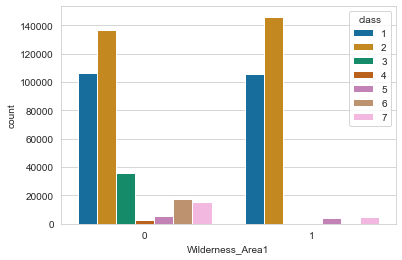

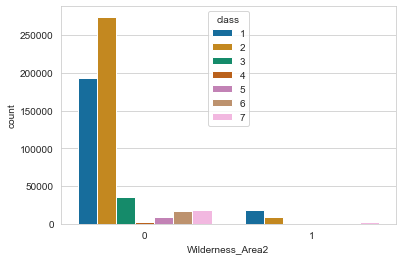

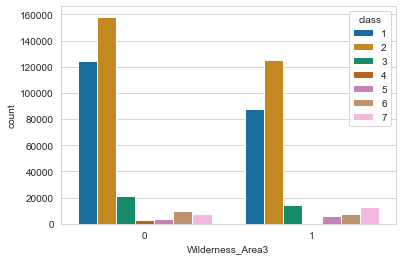

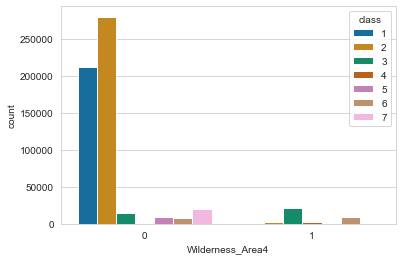

In [52]:
for i in range(4):
    countplot_wilderness = plt.figure()
    sns.countplot(x=f'Wilderness_Area{i+1}', hue='class', data=data[list(data.columns[10:14]) + ['class']], palette='colorblind')
    countplot_wilderness.savefig(f'Wilderness_Area_countplot_{i+1}.png')

In [67]:
wilderness_class_tables = []
for i in range(4):
    wilderness_class_table = data.groupby('class').mean()[f'Wilderness_Area{i+1}']
    wilderness_class_tables.append(wilderness_class_table)

wilderness_class_df = pd.DataFrame(wilderness_class_tables)

In [71]:
wilderness_class_df

class,1,2,3,4,5,6,7
Wilderness_Area1,0.499042,0.516048,0.000000,0.0,0.398293,0.000000,0.248708
Wilderness_Area2,0.087779,0.031715,0.000000,0.0,0.000000,0.000000,0.112335
Wilderness_Area3,0.413180,0.441555,0.399955,0.0,0.601707,0.439109,0.638957
Wilderness_Area4,0.000000,0.010681,0.600045,1.0,0.000000,0.560891,0.000000


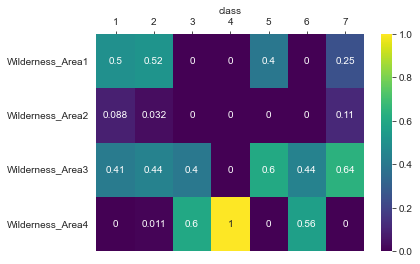

In [95]:
wilderness_heatmap = plt.figure()
g = sns.heatmap(wilderness_class_df, cmap='viridis', annot=True)
g.axes.xaxis.set_ticks_position("top")
g.xaxis.set_label_position('top') 

wilderness_heatmap.savefig('wilderness_heatmap.png', bbox_inches='tight')

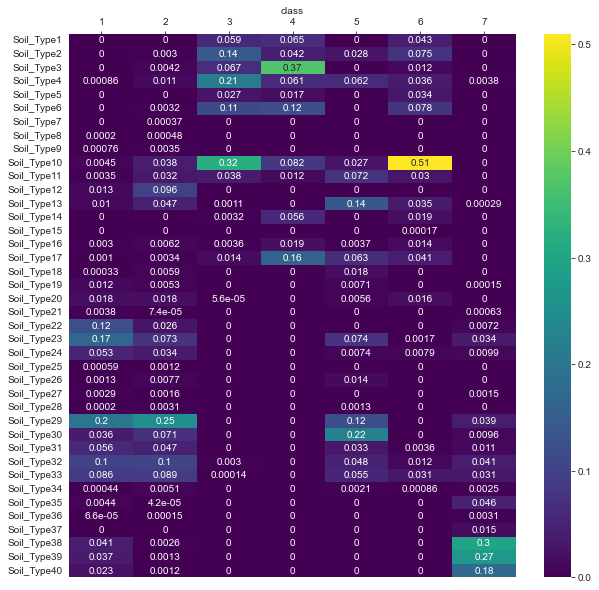

In [96]:
soiltype_class_tables = []
for i in range(40):
    soiltype_class_table = data.groupby('class').mean()[f'Soil_Type{i+1}']
    soiltype_class_tables.append(soiltype_class_table)

soiltype_class_df = pd.DataFrame(soiltype_class_tables)

soiltype_heatmap = plt.figure(figsize=(10,10))
g = sns.heatmap(soiltype_class_df, cmap='viridis', annot=True)
g.axes.xaxis.set_ticks_position("top")
g.xaxis.set_label_position('top') 
soiltype_heatmap.savefig('soiltype_heatmap.png', bbox_inches='tight')

### Preprocessing

Since categorical variables were already dummified, the only preprocessing steps necessary are feature scaling and label encoding.

In [11]:
# seperate predictors from the target
y = data['class']
X = data.iloc[:,:-1]

In [104]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
X_train.shape, X_test.shape

((464809, 54), (116203, 54))

In [105]:
# scaling the features
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)

In [125]:
# label encoding
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### Modelling

In [199]:
model = tf.keras.models.Sequential()

# input layer
model.add(layers.InputLayer(input_shape=(X_train.shape[1],)))

# hidden layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(14, activation='relu'))

# output layer
model.add(layers.Dense(7, activation='softmax'))

model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(0.005), metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()])

model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_59 (Dense)            (None, 256)               14080     
                                                                 
 dense_60 (Dense)            (None, 128)               32896     
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_61 (Dense)            (None, 64)                8256      
                                                                 
 dense_62 (Dense)            (None, 32)                2080      
                                                                 
 dense_63 (Dense)            (None, 14)                462       
                                                                 
 dense_64 (Dense)            (None, 7)               

In [200]:
# model fitting
history = model.fit(X_train, y_train, epochs=30, batch_size=512, validation_split=0.3)

Epoch 1/30


2022-01-16 13:40:38.881215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


635/636 [============================>.] - ETA: 0s - loss: 0.5925 - categorical_accuracy: 0.7511 - auc_8: 0.9674

2022-01-16 13:40:47.932544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


636/636 [==============================] - 12s 19ms/step - loss: 0.5924 - categorical_accuracy: 0.7511 - auc_8: 0.9674 - val_loss: 0.5008 - val_categorical_accuracy: 0.7860 - val_auc_8: 0.9761
Epoch 2/30
636/636 [==============================] - 12s 19ms/step - loss: 0.4685 - categorical_accuracy: 0.8016 - auc_8: 0.9789 - val_loss: 0.4209 - val_categorical_accuracy: 0.8242 - val_auc_8: 0.9828
Epoch 3/30
636/636 [==============================] - 12s 19ms/step - loss: 0.4248 - categorical_accuracy: 0.8221 - auc_8: 0.9826 - val_loss: 0.3833 - val_categorical_accuracy: 0.8403 - val_auc_8: 0.9859
Epoch 4/30
636/636 [==============================] - 12s 19ms/step - loss: 0.3967 - categorical_accuracy: 0.8343 - auc_8: 0.9847 - val_loss: 0.3638 - val_categorical_accuracy: 0.8490 - val_auc_8: 0.9872
Epoch 5/30
636/636 [==============================] - 12s 20ms/step - loss: 0.3759 - categorical_accuracy: 0.8432 - auc_8: 0.9862 - val_loss: 0.3416 - val_categorical_accuracy: 0.8577 - val_auc_8

In [217]:
# save the model
model.save('./')

INFO:tensorflow:Assets written to: ./assets


### Model Evaluation

In [220]:
# load the model
model = tf.keras.models.load_model('./')

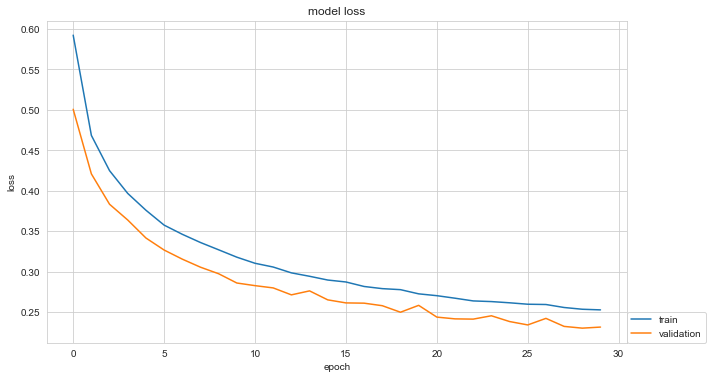

In [201]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(2, 1, 1)


ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.set_title('model loss')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc=[1,0])
fig.tight_layout()
fig.savefig('loss_curve.png')

plt.show()

In [221]:
loss, acc, auc = model.evaluate(X_test, y_test)

y_estimate = model.predict(X_test)
y_estimate = np.argmax(y_estimate, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_estimate))

   1/3632 [..............................] - ETA: 14:12 - loss: 0.0431 - categorical_accuracy: 1.0000 - auc_8: 1.0000

2022-01-16 14:06:04.362807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3632/3632 [==============================] - 31s 8ms/step - loss: 0.2306 - categorical_accuracy: 0.9097 - auc_8: 0.9943


2022-01-16 14:06:34.984613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.93      0.90      0.91     42421
           1       0.91      0.94      0.93     56407
           2       0.88      0.88      0.88      7170
           3       0.90      0.60      0.72       580
           4       0.82      0.58      0.68      1912
           5       0.79      0.81      0.80      3524
           6       0.93      0.91      0.92      4189

    accuracy                           0.91    116203
   macro avg       0.88      0.80      0.83    116203
weighted avg       0.91      0.91      0.91    116203



<Figure size 720x720 with 0 Axes>

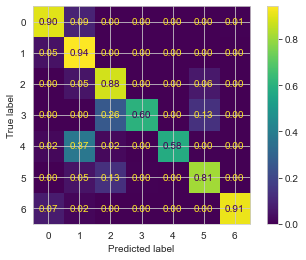

In [223]:
plt.figure(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(y_true, y_estimate, normalize='true', values_format='.2f')
plt.savefig("conf_matrix_plot.png")
plt.show()